<a href="https://colab.research.google.com/github/megangrannan/Portfolio/blob/master/Coach_Viva_Email_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coach Viva Email Analysis - Hot Subscribers

# Project Goals:

Use email list data to:
1. Identify "hot" subscribers to target in our 30 day action plan, leading to an increase in sales conversions
2. Improve the quality of our email list by removing unengaged subscribers who are unlikely to ever make a purchase
3. Automate output - 2 CSV files with hot subscribers and inactive subscribers

In order to meet these goals, we will investigate the following questions:

- What is our average open and click rate for emails?
- How do open and click rates correlate with time on email list?
- How can we identify subscribers who are "hot", i.e. more engaged than typical?
- How can we reliably identify subscribers who have low engagement levels?


# Project Outline:
1. Obtain data: API requests and web scraping
2. Clean and format data: 
    - Clean, format, and filter email data from `email_conversions.txt`
    -  Aggregate data on the subscriber level
3. Preliminary analysis - mean and median open and click rates across subscribers
4. Gather and merge additional data into dataframe 
    - API requests - subscriber and purchase data
    - Clean and format new data  
    - Merge new data into dataframe
5. Analysis 
    - Aggregate subscribers based on time on email list
    - Analysis of time on email list vs. open and click rates for subscribers who have and haven't purchased our target product
    - Identifying hot subscribers - high click and/or open rates compared to segment and typical activity. Special case - new subscribers
    - Identifying inactive subscribers 
6. Output - 2 CSV files with hot subscriber and inactive subscriber customer segments to target during our 30 day action plan

  



# Code Excerpts
Below are several code excerpts from my work on this project.

Code exerpts follow the general workflow of the project - gathering data, cleaning/formatting data, and aggregating/analyzing data.



# Prepare Data for Analysis

Now that we have gathered the relevant email data, we will import this file and clean the data in preparation for analysis.

## Import and clean data from `email_conversions.txt`

First, we will import the data from the `email_conversions.txt` file into a dataframe. Then, we will clean and format the data.

In [ ]:
# Import 'email_conversions.txt'
uploaded = files.upload()

In [ ]:
# Load data into dictionary
email_conversions = json.loads(uploaded['email_conversions.txt'].decode('utf-8'))

In [ ]:
# Load the dictionary as a dataframe
email_conversions = pd.DataFrame.from_dict(email_conversions, orient='index')

In [ ]:
email_conversions.sample()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219
686867598,"[[delivered, ], Delivered Oct 07, 2020 at 12:4...","[[delivered, ], Delivered Oct 04, 2020 at 6:11...","[[delivered, ], Delivered Oct 02, 2020 at 7:06...","[[delivered, ], Delivered Sep 30, 2020 at 9:10...","[[delivered, ], Delivered Sep 27, 2020 at 5:30...","[[delivered, ], Delivered Sep 25, 2020 at 5:30...","[[delivered, ], Delivered Sep 23, 2020 at 9:10...","[[delivered, ], Delivered Sep 20, 2020 at 5:42...","[[delivered, ], Delivered Sep 16, 2020 at 11:1...","[[opened, ], Opened Sep 11, 2020 at 9:33pm PDT...","[[delivered, ], Delivered Sep 09, 2020 at 5:36...","[[delivered, ], Delivered Sep 06, 2020 at 5:30...","[[delivered, ], Delivered Sep 02, 2020 at 5:30...","[[delivered, ], Delivered Aug 30, 2020 at 5:30...","[[delivered, ], Delivered Aug 28, 2020 at 5:30...","[[delivered, ], Delivered Aug 26, 2020 at 3:28...","[[delivered, ], Delivered Aug 23, 2020 at 7:00...","[[delivered, ], Delivered Aug 21, 2020 at 5:30...","[[delivered, opened, ], Opened Aug 20, 2020 at...","[[delivered, ], Delivered Aug 16, 2020 at 5:30...","[[delivered, ], Delivered Aug 14, 2020 at 4:36...","[[delivered, ], Delivered Aug 12, 2020 at 5:15...","[[delivered, ], Delivered Aug 09, 2020 at 7:17...","[[delivered, ], Delivered Aug 07, 2020 at 5:30...","[[delivered, ], Delivered Aug 05, 2020 at 1:30...","[[delivered, ], Delivered Aug 02, 2020 at 6:01...","[[delivered, ], Delivered Aug 01, 2020 at 6:00...","[[delivered, ], Delivered Jul 31, 2020 at 6:02...","[[delivered, ], Delivered Jul 30, 2020 at 5:05...","[[delivered, ], Delivered Jul 30, 2020 at 5:00...","[[delivered, ], Delivered Jul 30, 2020 at 4:45...","[[delivered, ], Delivered Jul 30, 2020 at 4:00...","[[delivered, ], Delivered Jul 30, 2020 at 6:00...","[[delivered, ], Delivered Jul 29, 2020 at 6:00...","[[delivered, ], Delivered Jul 28, 2020 at 6:04...","[[delivered, opened, ], Opened Jul 27, 2020 at...","[[delivered, ], Delivered Jul 26, 2020 at 4:11...","[[delivered, opened, ], Opened Jul 26, 2020 at...","[[delivered, ], Delivered Jul 24, 2020 at 4:54...","[[delivered, ], Delivered Jul 22, 2020 at 1:10...",...,"[[delivered, ], Delivered Jan 07, 2020 at 4:15...","[[delivered, ], Delivered Jan 06, 2020 at 7:12...","[[delivered, ], Delivered Jan 06, 2020 at 4:15...","[[delivered, ], Delivered Jan 05, 2020 at 7:13...","[[delivered, ], Delivered Jan 04, 2020 at 7:13...","[[delivered, ], Delivered Jan 03, 2020 at 7:11...","[[delivered, opened, ], Opened Jan 02, 2020 at...","[[delivered, opened, clicked], Clicked Jan 02,...","[[delivered, opened, clicked], Clicked Jan 03,...","[[delivered, opened, clicked], Clicked Jan 02,...",190,"[All Prospects, Broadcast Audience]","None, None",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,None,None


In [ ]:
# Save all email data in 1 column
email_conversions['email_data'] = email_conversions.iloc[:, :].to_numpy().tolist()

In [ ]:
# Drop other columns from dataframe
email_conversions.drop(email_conversions.iloc[:, :-1], inplace=True, axis=1)

In [ ]:
# Drop null values from email_data column
email_conversions['email_data'] = email_conversions['email_data'].apply(lambda x: [i for i in x if str(i) != 'None'])
email_conversions['email_data'] = email_conversions['email_data'].apply(lambda x: [i for i in x if str(i) != 'nan'])

In [ ]:
# Store number of emails and segments in separate columns and drop from `email_data`
email_conversions['number_emails'] = email_conversions['email_data'].apply(lambda x: x[-3]).astype(int)
email_conversions['segments'] = email_conversions['email_data'].apply(lambda x: x[-2])
email_conversions['location'] = email_conversions['email_data'].apply(lambda x: x[-1])
email_conversions['email_data'] = email_conversions['email_data'].apply(lambda x: x[:-3])

In [ ]:
# Clean `segments` column: subscriber in Broadcast or other
email_conversions['segments'] = email_conversions['segments'].apply(lambda x: 'Broadcast' if 'Broadcast Audience' in x else 'Other')

In [ ]:
# Broadcast vs other subscribers
email_conversions['segments'].value_counts(dropna=False)

Broadcast    666
Other        101
Name: segments, dtype: int64

In [ ]:
# Check data
email_conversions.sample(3)

,email_data,number_emails,segments,location
981621975,"[[[delivered, opened, ], Opened Oct 07, 2020 a...",18,Broadcast,"New York, New York"
906078991,"[[[delivered, ], Delivered Oct 07, 2020 at 12:...",53,Broadcast,"Mumbai, Maharashtra"
1021874855,"[[[delivered, ], Delivered Oct 07, 2020 at 12:...",5,Broadcast,"Philadelphia, Pennsylvania"


In [ ]:
# Copy total emails per subscriber for later use
total_emails = email_conversions['number_emails'].copy()

In [ ]:
# Copy location data for later use
location_data = email_conversions['location'].copy()

In [ ]:
# Create new data frame with each individual email in its own row
email_each = email_conversions.copy()
email_each = email_each.explode('email_data')

In [ ]:
# Preview data
email_each.tail()

,email_data,number_emails,segments,location
1027376462,"[[delivered, opened, clicked], Clicked Oct 06,...",6,Other,"None, None"
1027376462,"[[delivered, opened, clicked], Clicked Oct 06,...",6,Other,"None, None"
1027376462,"[[delivered, opened, clicked], Clicked Oct 06,...",6,Other,"None, None"
1027376462,"[[delivered, opened, clicked], Clicked Oct 06,...",6,Other,"None, None"
1028504022,"[[delivered, opened, clicked], Clicked Oct 07,...",1,Other,"Kissimmee, Florida"


In [ ]:
# Separate email_status, date_received, and date_sent into separate columns and drop original column
email_each[['email_status', 'date_received', 'date_sent']] = pd.DataFrame(email_each['email_data'].tolist(), index=email_each.index)
email_each.drop('email_data', axis=1, inplace=True)

In [ ]:
# Reset index and make subscriber_id a column
email_each.reset_index(inplace=True)
email_each.rename(columns={'index':'subscriber_id'}, inplace=True)

In [ ]:
# Locate and drop emails missing email status
drop_list = email_each.loc[email_each['email_status'].map(len)==1].index
email_each.drop(drop_list, inplace=True)

In [ ]:
# Preview data
email_each.tail()

,subscriber_id,number_emails,segments,location,email_status,date_received,date_sent
57246,1027376462,6,Other,"None, None","[delivered, opened, clicked]","Clicked Oct 06, 2020 at 6:35pm PDT","Oct 06, 2020 at 6:31pm PDT"
57247,1027376462,6,Other,"None, None","[delivered, opened, clicked]","Clicked Oct 06, 2020 at 6:31pm PDT","Oct 06, 2020 at 5:22pm PDT"
57248,1027376462,6,Other,"None, None","[delivered, opened, clicked]","Clicked Oct 06, 2020 at 4:30pm PDT","Oct 06, 2020 at 4:22pm PDT"
57249,1027376462,6,Other,"None, None","[delivered, opened, clicked]","Clicked Oct 06, 2020 at 4:22pm PDT","Oct 06, 2020 at 4:21pm PDT"
57250,1028504022,1,Other,"Kissimmee, Florida","[delivered, opened, clicked]","Clicked Oct 07, 2020 at 1:03pm PDT","Oct 07, 2020 at 1:03pm PDT"


In [ ]:
# Write a function to categorize emails
def email_cat(x):
  if 'clicked' in x:
    status = 'clicked'
  elif 'opened' in x:
    status = 'opened'
  else:
    status = 'delivered'
  return status

In [ ]:
# Categorize emails according to their status
email_each['email_status'] = email_each['email_status'].apply(email_cat)

In [ ]:
email_each.tail()

,subscriber_id,number_emails,segments,location,email_status,date_received,date_sent
57246,1027376462,6,Other,"None, None",clicked,"Clicked Oct 06, 2020 at 6:35pm PDT","Oct 06, 2020 at 6:31pm PDT"
57247,1027376462,6,Other,"None, None",clicked,"Clicked Oct 06, 2020 at 6:31pm PDT","Oct 06, 2020 at 5:22pm PDT"
57248,1027376462,6,Other,"None, None",clicked,"Clicked Oct 06, 2020 at 4:30pm PDT","Oct 06, 2020 at 4:22pm PDT"
57249,1027376462,6,Other,"None, None",clicked,"Clicked Oct 06, 2020 at 4:22pm PDT","Oct 06, 2020 at 4:21pm PDT"
57250,1028504022,1,Other,"Kissimmee, Florida",clicked,"Clicked Oct 07, 2020 at 1:03pm PDT","Oct 07, 2020 at 1:03pm PDT"


Since we are interested in analyzing subscribers who have received 5 or more emails, we will filter the data to only focus on this group.

In [ ]:
# Filter data set to only include subscribers who have received 5 or more emails
email_each_5 = email_each.loc[email_each['number_emails'] >= 5].copy()

In [ ]:
# Get segment by subscriber id
segs = email_each_5.groupby('subscriber_id')['segments'].first()
segs

## Data aggregation 

Next, we will aggregate the emails by unique subscriber id in order to find each subscriber's individual open and click rates.

In [ ]:
# Aggregate emails to see the open and click rate for each subscriber
email_test = email_each_5.groupby(['subscriber_id', 'email_status'])['subscriber_id'].count().to_frame()
email_test['percentage'] = email_test.groupby(level=0).apply(lambda x: round(x / x.sum() * 100, 2))
email_test

subscriber_id  percentage
subscriber_id email_status                           
1000528074    delivered                12       92.31
              opened                    1        7.69
1000550785    delivered                 6       46.15
              opened                    7       53.85
1000619946    clicked                   1        7.69
...                                   ...         ...
999434449     opened                    2       15.38
999859113     clicked                   1        7.14
              delivered                13       92.86
999908122     delivered                11       84.62
              opened                    2       15.38

[1815 rows x 2 columns]

In [ ]:
# Summary of open and click rates
email_test.groupby(level='email_status').describe()

subscriber_id                        ... percentage                
                     count       mean        std  ...        50%     75%     max
email_status                                      ...                           
clicked              443.0   2.812641   3.184894  ...       3.87   9.090   66.67
delivered            736.0  53.330163  51.909009  ...      81.25  93.945  100.00
opened               636.0  25.915094  38.731123  ...      21.49  42.860   99.44

[3 rows x 16 columns]

For our email subscribers who have received 5 or more emails:
* The average (mean) open rate is 29%, and the median open rate is 21%
* The average (mean) click rate is 7.6%, and the median click rate is 3.9%

In [ ]:
# Save total median click and open rates
total_median_click = email_test.groupby(level='email_status')['percentage'].median().loc['clicked']
total_median_open = email_test.groupby(level='email_status')['percentage'].median().loc['opened']

Finally, we will reformat the dataframe so that each subscriber's open and click rate data is in one row. Later, this will allow us to merge this dataframe with data from other sources.

In [ ]:
# Reformat dataframe
email_rates = email_test.unstack()
email_rates

subscriber_id                  percentage                 
email_status        clicked delivered opened    clicked delivered opened
subscriber_id                                                           
1000528074              NaN      12.0    1.0        NaN     92.31   7.69
1000550785              NaN       6.0    7.0        NaN     46.15  53.85
1000619946              1.0       4.0    8.0       7.69     30.77  61.54
1000894846              NaN      11.0    1.0        NaN     91.67   8.33
1000904683              1.0      12.0    NaN       7.69     92.31    NaN
...                     ...       ...    ...        ...       ...    ...
998392933               NaN      13.0    2.0        NaN     86.67  13.33
998667509               NaN       5.0    8.0        NaN     38.46  61.54
999434449               NaN      11.0    2.0        NaN     84.62  15.38
999859113               1.0      13.0    NaN       7.14     92.86    NaN
999908122               NaN      11.0    2.0        NaN     84.62  15.38

[749 rows x 6 columns]

# Gather and Merge Additional Data Into Dataframe

We will make additional API requests to gather the following information: subscriber email address, subscriber purchased target product, and subscriber time on email list. As we gather this information, we will clean and format it, and merge it into our `email_rates` dataframe.

First, we'll make an API request for subscribers who have purchased target product.

Now, we will add this purchase data to our dataframe.

In [ ]:
# Convert to flat index and rename columns
email_rates.columns = ['_'.join(col) for col in email_rates.columns.values]
email_rates.columns = ['emails_clicked', 'emails_delivered', 'emails_opened', 'percent_clicked', 'percent_delivered', 'percent_opened']

In [ ]:
# Merge subscriber purchase info into `email_rates` dataframe
email_rates = email_rates.join(chat_coaching_purchased)

In [ ]:
# Merge subscriber segment into `email_rates` dataframe
email_rates = email_rates.join(segs)

In [ ]:
# Preview data
email_rates.sample(5)

,emails_clicked,emails_delivered,emails_opened,percent_clicked,percent_delivered,percent_opened,BBB_Purchased,segments
subscriber_id,,,,,,,,
968158319,NaN,14.0,3.0,NaN,82.35,17.65,NaN,Broadcast
829184062,1.0,85.0,3.0,1.12,95.51,3.37,NaN,Broadcast
974566184,3.0,7.0,1.0,27.27,63.64,9.09,NaN,Other
909928016,12.0,12.0,25.0,24.49,24.49,51.02,NaN,Broadcast
894400194,NaN,48.0,13.0,NaN,78.69,21.31,NaN,Broadcast


In [ ]:
# Create `BBB_Purchased` column in data frame and fill 'No' for subscribers who haven't purchased BBB
email_rates['BBB_Purchased'].fillna('No', inplace=True)

In [ ]:
# Fill `BBB_Purchased` column with 'Yes' for subscribers who have purchased BBB
email_rates['BBB_Purchased'] = email_rates['BBB_Purchased'].apply(lambda x:'Yes' if x != 'No' else x)

In [ ]:
# Preview data
email_rates.sample(5)

,emails_clicked,emails_delivered,emails_opened,percent_clicked,percent_delivered,percent_opened,BBB_Purchased,segments
subscriber_id,,,,,,,,
664953675,1.0,117.0,62.0,0.56,65.00,34.44,No,Broadcast
1015002175,NaN,7.0,1.0,NaN,87.50,12.50,No,Broadcast
914358619,6.0,42.0,13.0,9.84,68.85,21.31,No,Broadcast
847799702,1.0,79.0,1.0,1.23,97.53,1.23,No,Broadcast
664953721,3.0,98.0,61.0,1.85,60.49,37.65,No,Broadcast


Next, we'll make another API request to gather the subscriber's email address, id, and subscription date.

In [ ]:
# Creat dictionary to store email address, subscriber id, and subscription date
subscriber_data = defaultdict(list)

# Base url to make request
url = 'https://api.convertkit.com/v3/subscribers?api_secret=REMOVED'
response = requests.get(url)
response_j = response.json() 

# Count total pages in response
total_pages = response_j['total_pages']
  
# Store relevant subscriber info in dictionary
for subscriber in response_j['subscribers']:
  id = subscriber['id']
  subscriber_data[id].append(subscriber['email_address'])
  subscriber_data[id].append(subscriber['first_name'])
  subscriber_data[id].append(subscriber['created_at'])
  subscriber_data[id].append(subscriber['fields']['legacy_optintime'])

# Make requests for any additional pages, and count results 
for i in range(2, total_pages+1):
  new_url = url + '&page=' + str(i)
  response = requests.get(new_url)
  response_j = response.json()

  for subscriber in response_j['subscribers']:
    id = subscriber['id']
    subscriber_data[id].append(subscriber['email_address'])
    subscriber_data[id].append(subscriber['first_name'])
    subscriber_data[id].append(subscriber['created_at'])
    subscriber_data[id].append(subscriber['fields']['legacy_optintime'])

In [ ]:
# Preview data - personal info removed
subscriber_data[['CK_subscription', 'legacy_subscription']].sample(5)

,CK_subscription,legacy_subscription
664953729,2019-12-07T01:38:34.000Z,2018-07-04 11:18:12
1070916550,2020-11-15T02:35:40.000Z,None
1035545365,2020-10-14T13:07:28.000Z,None
914942911,2020-07-09T14:03:06.000Z,None
978347736,2020-08-27T16:04:28.000Z,None


We will need to clean this data. We'll extract the correct subscription time (this information is spread across two columns due to a legacy email list, before we switched to our current email management system). We will use that to calculate how long the subscriber has been on our email list.

In [ ]:
# Write a function to convert the `CK_subscription` dates into datetime objects
def convert_date(d):
  new_date = dt.datetime.strptime(d, "%Y-%m-%dT%H:%M:%S.%fZ")
  return new_date.date()

In [ ]:
# Convert `CK_subscription` column to datetime
subscriber_data['CK_subscription'] = subscriber_data['CK_subscription'].apply(convert_date)

In [ ]:
# Modify above function for `legacy_subscription` column
def convert_date(d):
  if d != None:
    new_date = dt.datetime.strptime(d, "%Y-%m-%d %H:%M:%S")
    return new_date.date()

In [ ]:
# Convert `legacy_subscription` column to datetime
subscriber_data['legacy_subscription'] = subscriber_data['legacy_subscription'].apply(convert_date)

In [ ]:
# Define a function to choose the correct subscription date
def sub_date(row):
  if row['legacy_subscription'] != None:
    return row['legacy_subscription']
  else:
    return row['CK_subscription']

In [ ]:
# Create a new `subscription_date` column with the correct subscription date
subscriber_data['subscription_date'] = subscriber_data.apply(sub_date, axis=1)

In [ ]:
# Drop `CK_subscription` and `legacy_subscription`
subscriber_data.drop(['CK_subscription', 'legacy_subscription'], axis=1, inplace=True)

In [ ]:
# Add a new column that tells how long the subscriber has been on our email list
subscriber_data['time_since_sub'] = pd.to_datetime('now').date() - subscriber_data['subscription_date']

In [ ]:
# Preview data - personal info removed
subscriber_data[['subscription_date', 'time_since_sub']].sample(5)

,subscription_date,time_since_sub
1051627077,2020-10-28,18 days
664953699,2018-08-13,825 days
664953614,2018-11-20,726 days
1025086074,2020-10-05,41 days
906123346,2020-07-01,137 days


We are ready to merge this data into our dataframe.

In [ ]:
# Merge subscriber data into `email_rates` dataframe
email_rates = email_rates.join(subscriber_data)

In [ ]:
# Preview data
email_rates[['emails_clicked',
 'emails_delivered',
 'emails_opened',
 'percent_clicked',
 'percent_delivered',
 'percent_opened',
 'BBB_Purchased',
 'segments',
 'subscription_date',
 'time_since_sub']].sample(5)

,emails_clicked,emails_delivered,emails_opened,percent_clicked,percent_delivered,percent_opened,BBB_Purchased,segments,subscription_date,time_since_sub
subscriber_id,,,,,,,,,,
849586657,2.0,51.0,4.0,3.51,89.47,7.02,No,Broadcast,2020-05-17,182 days
969364947,5.0,NaN,9.0,35.71,NaN,64.29,No,Other,2020-08-20,87 days
915187503,1.0,41.0,10.0,1.92,78.85,19.23,No,Broadcast,2020-07-09,129 days
821581036,14.0,80.0,1.0,14.74,84.21,1.05,No,Broadcast,2020-04-24,205 days
924783676,1.0,37.0,4.0,2.38,88.10,9.52,No,Broadcast,2020-07-17,121 days


# Aggregate subscribers by time on email list

Now that we know our overall open and click rates, and have compared this to our subscribers who have purchased BBB, we will look at subscribers' open and click rates on a more granular level. We will now only look at subscribers who have not purchased BBB.

Specifically, we will group subscribers by how long they have been on our email list (<1 month, 1-3 months, 3-6 months, 6-12 months, 12-24 months, and >24 months). For each of these groups, we will find the mean and median open and click rates. 

First, we will classify subscribers based on how long they have been on our email list.

In [ ]:
# Format time since subscription as an integer
email_rates['time_since_sub'] = email_rates['time_since_sub'].dt.days

In [ ]:
# Drop 4 rows with inaccurate data from people who are now unsubscribed
email_rates.dropna(subset=['email'], inplace=True)

In [ ]:
# Write a function to classify subscribers based on time on list
def time_cat(x):
  if x <30:
    return '< 1 mo'
  elif x < 91:
    return '1-3 mos'
  elif x < 183:
    return '3-6 mos'
  elif x < 365:
    return '6-12 mos'
  elif x < 730:
    return '12-24 mos'
  else:
    return '> 24 mos'

In [ ]:
# Apply function to categorize subscribers
email_rates['time_cat'] = email_rates['time_since_sub'].apply(time_cat)

In [ ]:
# Preview data - personal info removed
email_rates[['emails_clicked',
 'emails_delivered',
 'emails_opened',
 'percent_clicked',
 'percent_delivered',
 'percent_opened',
 'BBB_Purchased',
 'segments',
 'subscription_date',
 'time_since_sub',
 'time_cat']].sample(5)

,emails_clicked,emails_delivered,emails_opened,percent_clicked,percent_delivered,percent_opened,BBB_Purchased,segments,subscription_date,time_since_sub,time_cat
subscriber_id,,,,,,,,,,,
726985916,3.0,112.0,63.0,1.69,62.92,35.39,No,Broadcast,2020-02-09,280,6-12 mos
664953610,NaN,123.0,84.0,NaN,59.42,40.58,No,Broadcast,2018-12-28,688,12-24 mos
664953718,NaN,168.0,38.0,NaN,81.55,18.45,No,Broadcast,2018-08-09,829,> 24 mos
993810842,1.0,39.0,1.0,2.44,95.12,2.44,No,Broadcast,2020-09-08,68,1-3 mos
899118793,NaN,74.0,8.0,NaN,90.24,9.76,No,Broadcast,2020-06-25,143,3-6 mos


Next, we'll filter our data to only include subscribers who haven't purchased BBB.

In [ ]:
# Filter for subscribers who haven't purchased BBB
no_bbb = email_rates.loc[email_rates['BBB_Purchased']=='No'].copy()
no_bbb.sample(5)

In [ ]:
# Save subscriber id, open rate, click rate, time category in another dataframe for later use
subscriber_summary = no_bbb[['percent_clicked', 'percent_opened', 'time_cat']].copy()

Next, we'll calculate the mean and median open and click rates for subscribers in each time category.

In [ ]:
# Calculate the mean and median open and click rates
summary_rates = no_bbb.groupby('time_cat')[['percent_opened', 'percent_clicked']].agg(['mean', 'median'])
summary_rates = summary_rates.iloc[[-2,0,2,3,1,-1]]
summary_rates = summary_rates.round(2)
summary_rates

percent_opened        percent_clicked       
                    mean median            mean median
time_cat                                              
< 1 mo             35.54  33.33           15.39  11.11
1-3 mos            21.71  14.29            7.61   4.76
3-6 mos            18.87  12.80            3.24   1.90
6-12 mos           13.84   7.81            3.02   1.72
12-24 mos          27.18  14.69            2.20   1.44
> 24 mos           38.30  33.01            1.55   0.97

In [ ]:
# Rename columns
summary_rates.columns = [' '.join(col).strip() for col in summary_rates.columns.values]

In [ ]:
# Save median open and click rates for later use
median_click_cats = dict(zip(summary_rates.index, summary_rates['percent_clicked median']))
median_open_cats = dict(zip(summary_rates.index, summary_rates['percent_opened median']))

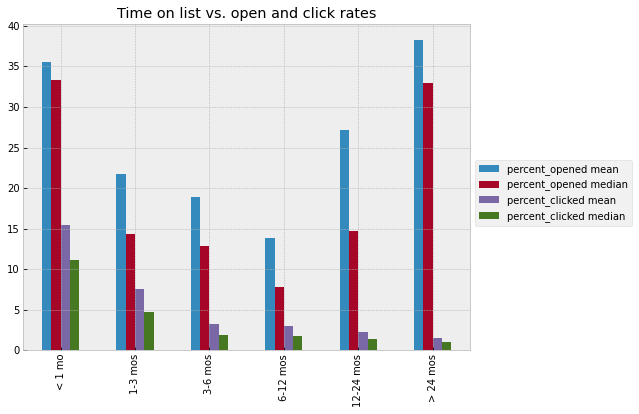

In [ ]:
# Open and click rates vs. time on list
fig, ax = plt.subplots(figsize=(8,6))
summary_rates.plot(kind='bar', ax=ax)
plt.legend(bbox_to_anchor = (1, .6))
plt.xlabel('')
plt.title('Time on list vs. open and click rates')
plt.show()

We can observe the following:
* New subscribers who have been on our email list for < 1 month have high open and click rates
* Open and click rates decline for subscribers who have been on our email list for longer than a month, up to 1 year
* Interestingly, subscribers who have been on our list for > 1 year have the highest open rates. In contrast, they have the lowest click rates. This category includes any subscribers from our ambassador list. 

Let's take a closer look at these > 1 year old subscribers (removed).

Many of these veteran subscribers with high open rates are from our ambassador list. This includes family members and friends, along with former chat coaching clients, who may be very interested in following Coach Viva, but who are not likely to purchase BBB. We can observe that many of these same subscribers have very low click rates.

Previosly, we used open rates to identify and remove inactive subscribers from our email list. This analysis suggests that click rates may be a better metric to use.

# Hot and Inactive Subscriber Analysis

Since we want to target subscribers in the Broadcast Audience segment, we'll first filter our data to only focus on this target segment.

In [ ]:
# Filter dataframe for broadcast segment
bcast_seg = no_bbb.loc[no_bbb.segments == 'Broadcast'].copy()

In [ ]:
# Subscribers vs. time on list
bcast_seg['time_cat'].value_counts()

1-3 mos      234
3-6 mos      204
> 24 mos     127
< 1 mo       119
6-12 mos      68
12-24 mos     52
Name: time_cat, dtype: int64

## Top Click Rates vs. Time on List

We will identify the top 10 subscribers with the highest click rates from each time category. 

In [ ]:
# Sort by click rate
bcast_seg.sort_values('percent_clicked', ascending=False, inplace=True)

In [ ]:
# Aggregate by top 10 clickers per time on list
top_clicks = bcast_seg.groupby(['time_cat'])['percent_clicked'].nlargest(10)

In [ ]:
# Reformat to dataframe
top_clicks = top_clicks.to_frame()
top_clicks = top_clicks.reset_index(level=[1])

In [ ]:
# Add subscribers' emails and see results
top_clicks = top_clicks.join(bcast_seg.email, on='subscriber_id')

In [ ]:
# Subscribers with highest click rates per time category
top_clicks[["subscriber_id", "percent_clicked"]]

,subscriber_id,percent_clicked
time_cat,,
1-3 mos,1023214905,19.35
1-3 mos,1031297781,17.86
1-3 mos,1004842004,17.78
1-3 mos,1027376462,14.71
1-3 mos,1023765079,12.90
1-3 mos,1011278102,12.82
1-3 mos,1031420140,12.50
1-3 mos,1035446598,10.71
1-3 mos,1009139809,10.53


In [ ]:
# Create time group segments
groups = top_clicks.index.unique()
groups

Index(['1-3 mos', '12-24 mos', '3-6 mos', '6-12 mos', '< 1 mo', '> 24 mos'], dtype='object', name='time_cat')

In [ ]:
# Order time group segments
order = [4, 0, 2, 3, 1, 5]
groups_ordered = [groups[i] for i in order]

In [ ]:
#Check groups have been ordered correctly
groups_ordered

['< 1 mo', '1-3 mos', '3-6 mos', '6-12 mos', '12-24 mos', '> 24 mos']

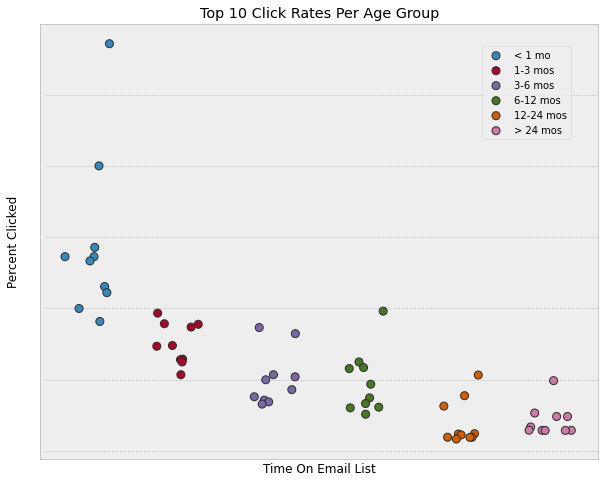

In [ ]:
# Plot the top 10 highest click rates for each time group
fig, ax = plt.subplots(figsize=(10,8))
sns.stripplot(x=top_clicks.index, y='percent_clicked', data=top_clicks, order=groups_ordered, s=8, linewidth=1, jitter=.25)
plt.ylabel('Percent Clicked')
plt.xlabel('Time On Email List')
plt.xticks(labels=None)
plt.legend(groups_ordered, bbox_to_anchor=[.96, .96])
ax.set_xticks([])
ax.tick_params(colors='white')
plt.title('Top 10 Click Rates Per Age Group')
plt.show()

## Inactive Subscribers 

We want to reliably identify inactive subscribers based on email data. 

We will explore our email data to understand what inactive subscribers look like. We will start by looking at subscribers who have opened no emails in the past 1, 2, 3, 4, 5, or 6 months. We will compare this to subscribers who have not clicked on any emails in the past 1, 2, 3, 4, 5, or 6 months.

Since we're only interested in looking at subscribers in the broadcast segment, we'll first get a list of their subscriber ids and use this to filter our email data.

In [ ]:
# Generate list of subscriber ids for broadcast segment and filter data
bcast_subs = bcast_seg.index.to_list()
email_each_bcast = email_each_5.loc[email_each_5['subscriber_id'].isin(bcast_subs)].copy()

In [ ]:
# Merge with subscriber data
email_each_bcast = email_each_bcast.join(subscriber_data, on='subscriber_id')

In [ ]:
# Create list of cutoff dates for past 6 months
cutoff_dates = list()
for i in range(1,7):
  cutoff_date = dt.date.today() - dateutil.relativedelta.relativedelta(months=i)
  cutoff_dates.append(np.datetime64(cutoff_date))

In [ ]:
# Cutoff dates for past 6 months
cutoff_dates

[numpy.datetime64('2020-10-15'),
 numpy.datetime64('2020-09-15'),
 numpy.datetime64('2020-08-15'),
 numpy.datetime64('2020-07-15'),
 numpy.datetime64('2020-06-15'),
 numpy.datetime64('2020-05-15')]

In [ ]:
# Reformat `date_sent` column to datetime format
email_each_bcast['date_sent'] = email_each_bcast['date_sent'].apply(lambda x: x[:-4]).apply(lambda x: dt.datetime.strptime(x, '%b %d, %Y at %I:%M%p'))

In [ ]:
# Find the number of subscribers who haven't opened/clicked on any emails in the past x months
# Make a list of subscriber emails for subscribers who haven't clicked any emails in past 6 months
for idx, date in enumerate(cutoff_dates):
  filtered_data =  email_each_bcast.loc[(email_each_bcast['date_sent'] > cutoff_dates[idx]) & (email_each_bcast['subscription_date'] <= cutoff_dates[idx])]
  date_emails = filtered_data.groupby(['subscriber_id', 'email_status'])['subscriber_id'].count()
  date_emails = date_emails.to_frame().unstack()
  date_emails.fillna(0, inplace=True)
  date_emails.columns = date_emails.columns.get_level_values(1)
  no_opens = date_emails.loc[date_emails['opened']==0].shape[0]
  no_clicks = date_emails.loc[date_emails['clicked']==0].shape[0]
  print(f'No opens in past {idx+1} months:', no_opens)
  print(f'No clicks in past {idx+1} months:', no_clicks)
  if idx == 5:
    date_emails = date_emails.join(subscriber_data['email'])
    no_clicks_6_mo = date_emails.loc[date_emails['clicked']==0]['email'].to_list()

No opens in past 1 months: 273
No clicks in past 1 months: 635
No opens in past 2 months: 155
No clicks in past 2 months: 498
No opens in past 3 months: 103
No clicks in past 3 months: 393
No opens in past 4 months: 64
No clicks in past 4 months: 317
No opens in past 5 months: 36
No clicks in past 5 months: 231
No opens in past 6 months: 24
No clicks in past 6 months: 178


In [ ]:
# Number of subscribers with no clicks in past 6 monts
len(no_clicks_6_mo)

178

In [ ]:
# Save this list of inactive subscribers to a CSV for download later
no_clicks_6_mo = pd.DataFrame(no_clicks_6_mo)
no_clicks_6_mo.to_csv('no_clicks_past_6_mos.csv', index=True, header=False)

## Identifying "Hot" Subscribers

In order to identify "hot" subscribers, we'll analyze each subscriber's open and click rate for the last 10 emails. 

We'll compare that to their average open and click rates, as well as to the average open and click rates of their age cohort.

In [ ]:
# Filter for subscribers who have received >= 10 emails
email_each_bcast_10 = email_each_bcast.loc[email_each_bcast['number_emails'] >= 10].copy()
email_each_bcast_10.sort_values(['subscriber_id', 'date_sent'], ascending=False, inplace=True)

In [ ]:
# Select the 10 most recent emails for each subscriber
email_bcast_group = email_each_bcast_10.groupby(['subscriber_id']).head(10)
# Preview data
email_bcast_group.drop(columns=['location', 'email', 'first_name']).sample(5)

,subscriber_id,number_emails,segments,email_status,date_received,date_sent,subscription_date,time_since_sub
65619,987194793,42,Broadcast,opened,"Opened Nov 08, 2020 at 2:18pm PST",2020-11-08 06:00:00,2020-09-03,75 days
43695,818200701,113,Broadcast,delivered,"Delivered Nov 13, 2020 at 6:03am PST",2020-11-13 06:03:00,2020-04-21,210 days
26028,664953713,207,Broadcast,delivered,"Delivered Nov 08, 2020 at 6:00am PST",2020-11-08 06:00:00,2018-08-09,831 days
71718,1029509842,28,Broadcast,delivered,"Delivered Nov 08, 2020 at 6:00am PST",2020-11-08 06:00:00,2020-10-08,40 days
61286,946404018,66,Broadcast,delivered,"Delivered Nov 08, 2020 at 6:00am PST",2020-11-08 06:00:00,2020-08-03,106 days


In [ ]:
# Count number of clicked, opened, delivered emails for each subscriber, reformat data frame
past_10_emails = email_bcast_group.groupby(['subscriber_id', 'email_status'])['email_status'].count()
past_10_emails = past_10_emails.to_frame().unstack().fillna(0)

In [ ]:
# Rename columns
past_10_emails.columns = past_10_emails.columns.get_level_values(1)

In [ ]:
# Calculate % opened and % clicked for each subscriber for past 10 emails
past_10_emails['percent_opened'] = past_10_emails['opened'] * 10
past_10_emails['percent_clicked'] = past_10_emails['clicked'] * 10
past_10_emails

email_status,clicked,delivered,opened,percent_opened,percent_clicked
subscriber_id,,,,,
1000528074,0.0,9.0,1.0,10.0,0.0
1000894846,0.0,10.0,0.0,0.0,0.0
1000904683,0.0,10.0,0.0,0.0,0.0
1001155544,0.0,10.0,0.0,0.0,0.0
1001181990,0.0,10.0,0.0,0.0,0.0
...,...,...,...,...,...
998061600,0.0,10.0,0.0,0.0,0.0
998392933,0.0,9.0,1.0,10.0,0.0
998667509,1.0,4.0,5.0,50.0,10.0


In [ ]:
# Check distribution of data - % of subscribers with 0%, 10%, 20% etc of past 10 emails clicked
past_10_emails['percent_clicked'].value_counts(normalize=True)

0.0     0.949416
10.0    0.035019
20.0    0.014267
40.0    0.001297
Name: percent_clicked, dtype: float64

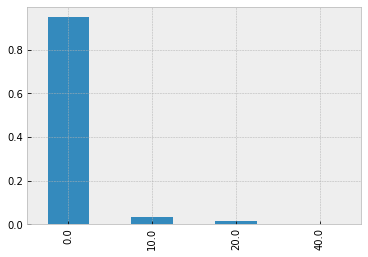

In [ ]:
# Check distribution of data - % of subscribers with 0%, 10%, 20% etc of past 10 emails clicked
past_10_emails['percent_clicked'].value_counts(normalize=True).plot.bar()

In [ ]:
# Check distribution of data - % of subscribers with 0%, 10%, 20% etc of past 10 emails opened
past_10_emails['percent_opened'].value_counts(normalize=True).sort_index()

0.0      0.526589
10.0     0.140078
20.0     0.088197
30.0     0.049287
40.0     0.045396
50.0     0.045396
60.0     0.033722
70.0     0.023346
80.0     0.025940
90.0     0.010376
100.0    0.011673
Name: percent_opened, dtype: float64

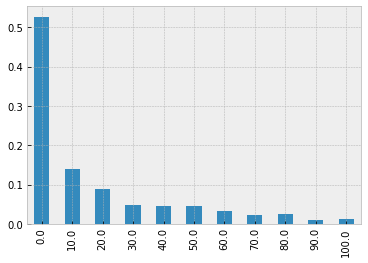

In [ ]:
# Check distribution of data - % of subscribers with 0%, 10%, 20% etc of past 10 emails opened
past_10_emails['percent_opened'].value_counts(normalize=True).sort_index().plot.bar()

In [ ]:
# Rename subscriber summary columns
subscriber_summary.columns=['avg_click_rate', 'avg_open_rate', 'time_cat']
subscriber_summary.fillna(0, inplace=True)
subscriber_summary.sample(5)

,avg_click_rate,avg_open_rate,time_cat
subscriber_id,,,
1037165496,3.85,3.85,1-3 mos
1036792717,6.25,93.75,1-3 mos
1009581932,0.00,0.00,1-3 mos
972894669,15.00,0.00,1-3 mos
664953580,0.00,6.80,12-24 mos


In [ ]:
# Join subscriber summary data into past 10 emails dataframe
past_10_emails = past_10_emails.join(subscriber_summary)

In [ ]:
# Join location data into past 10 emails dataframe
past_10_emails = past_10_emails.join(location_data)

In [ ]:
# Preview data
past_10_emails.sample(5)

,clicked,delivered,opened,percent_opened,percent_clicked,avg_click_rate,avg_open_rate,time_cat,location
subscriber_id,,,,,,,,,
996786149,0.0,9.0,1.0,10.0,0.0,0.00,7.69,1-3 mos,"N/A, N/A"
664953712,1.0,4.0,5.0,50.0,10.0,2.90,62.32,> 24 mos,"Kirkland, Washington"
1016285429,0.0,10.0,0.0,0.0,0.0,0.00,0.00,1-3 mos,"N/A, N/A"
664953608,0.0,1.0,9.0,90.0,0.0,2.44,91.71,12-24 mos,"Sarnia, Ontario"
881553249,0.0,9.0,1.0,10.0,0.0,2.06,10.31,3-6 mos,"Alhambra, California"


In [ ]:
# Add column - is current % clicked higher than subscriber's average % clicked
past_10_emails['higher_click'] = past_10_emails['percent_clicked'] > past_10_emails['avg_click_rate']

In [ ]:
# Subscribers who did vs did not have a higher click rate than their average for the past 10 emails
past_10_emails['higher_click'].value_counts()

False    746
True      25
Name: higher_click, dtype: int64

In [ ]:
# Inspect subscribers with a higher click rate
past_10_emails.loc[past_10_emails['higher_click']==True].drop(columns='location')

,clicked,delivered,opened,percent_opened,percent_clicked,avg_click_rate,avg_open_rate,time_cat,higher_click
subscriber_id,,,,,,,,,
1008557711,2.0,7.0,1.0,10.0,20.0,7.50,17.50,1-3 mos,True
1017376884,1.0,7.0,2.0,20.0,10.0,3.03,57.58,1-3 mos,True
1023765079,2.0,6.0,2.0,20.0,20.0,12.90,19.35,1-3 mos,True
1024783122,1.0,4.0,5.0,50.0,10.0,8.33,19.44,1-3 mos,True
1035257622,1.0,1.0,8.0,80.0,10.0,7.14,67.86,1-3 mos,True
1041338971,2.0,7.0,1.0,10.0,20.0,17.39,4.35,1-3 mos,True
1045330124,2.0,8.0,0.0,0.0,20.0,12.50,8.33,< 1 mo,True
1050368065,2.0,3.0,5.0,50.0,20.0,9.52,66.67,< 1 mo,True
1051363688,1.0,9.0,0.0,0.0,10.0,6.67,13.33,< 1 mo,True


In [ ]:
# Add column - is current % opened higher than subscriber's average % opened
past_10_emails['higher_open'] = past_10_emails['percent_opened'] > past_10_emails['avg_open_rate']

In [ ]:
# Subscribers who did vs did not have a higher open rate than their average for the past 10 emails
past_10_emails['higher_open'].value_counts()

False    573
True     198
Name: higher_open, dtype: int64

In [ ]:
# Subscribers with higher open and higher click rates
past_10_emails.loc[(past_10_emails['higher_open']==True) & (past_10_emails['higher_click']==True)].drop(columns=["location", 'first_name', 'email'])

,percent_opened,percent_clicked,avg_click_rate,avg_open_rate,time_cat,higher_click,higher_open,number_emails,median_open,median_click,higher_med_click,higher_med_open
subscriber_id,,,,,,,,,,,,
1023765079,20.0,20.0,12.90,19.35,1-3 mos,True,True,31,14.29,4.88,True,True
1024783122,50.0,10.0,8.33,19.44,1-3 mos,True,True,36,14.29,4.88,True,True
1035257622,80.0,10.0,7.14,67.86,1-3 mos,True,True,28,14.29,4.88,True,True
1041338971,10.0,20.0,17.39,4.35,1-3 mos,True,True,23,14.29,4.88,True,False
664943371,50.0,10.0,0.49,25.24,> 24 mos,True,True,207,32.76,0.97,True,True
664953588,60.0,10.0,7.77,44.66,12-24 mos,True,True,206,14.04,1.44,True,True
952103533,60.0,20.0,4.84,16.13,3-6 mos,True,True,62,13.33,1.90,True,True
996806497,20.0,10.0,4.76,11.90,1-3 mos,True,True,42,14.29,4.88,True,True
998667509,50.0,10.0,2.56,43.59,1-3 mos,True,True,39,14.29,4.88,True,True


In [ ]:
# Save subscriber email and name 
sub_info = subscriber_data[['email', 'first_name']].copy()

In [ ]:
# Merge subscriber email and name into dataframe
past_10_emails = past_10_emails.join(sub_info)

In [ ]:
# Merge total number of emails received into dataframe
past_10_emails = past_10_emails.join(total_emails)

In [ ]:
# Create columns to store median open and click rates for each subscriber age
past_10_emails['median_open'] = past_10_emails['time_cat'].map(median_open_cats)
past_10_emails['median_click'] = past_10_emails['time_cat'].map(median_click_cats)

In [ ]:
# Drop columns we no longer need from dataframe
past_10_emails.drop(columns=['clicked', 'delivered', 'opened'], inplace=True)

In [ ]:
# Add columns - did the subscriber have a higher open and/or click rate for the
# past 10 emails compared with their age cohort
past_10_emails['higher_med_click'] = past_10_emails['percent_clicked'] > past_10_emails['median_click']
past_10_emails['higher_med_open'] = past_10_emails['percent_opened'] > past_10_emails['median_open']

In [ ]:
# Preview data
past_10_emails.drop(columns=['location', 'email', 'first_name']).sample(5)

,percent_opened,percent_clicked,avg_click_rate,avg_open_rate,time_cat,higher_click,higher_open,number_emails,median_open,median_click,higher_med_click,higher_med_open
subscriber_id,,,,,,,,,,,,
881422781,0.0,0.0,1.04,3.12,3-6 mos,False,False,96,13.27,1.89,False,False
664953743,70.0,0.0,0.00,64.88,> 24 mos,False,True,205,32.76,0.97,False,True
992800309,70.0,0.0,7.32,68.29,1-3 mos,False,True,41,14.29,4.88,False,True
1015002175,10.0,0.0,0.00,8.82,1-3 mos,False,True,34,14.29,4.88,False,False
1042047284,10.0,0.0,4.17,8.33,< 1 mo,False,True,24,33.33,11.43,False,False


In [ ]:
# Subscribers who have received exactly 10 emails
past_10_emails.loc[past_10_emails['number_emails']==10].shape[0]

5

In [ ]:
# Distribution - number of subscribers who have received 10, 11, 12...20 emails
past_10_emails['number_emails'].value_counts().sort_index().head(10)

10     5
11    14
12    10
13    12
14     2
15     6
16     1
17     7
18     2
19     2
Name: number_emails, dtype: int64

In [ ]:
# Subscribers who have higher open and click rates then their average AND than their 
# subscriber age group's average
past_10_emails.loc[(past_10_emails['higher_open']==True) & (past_10_emails['higher_click']==True) & (past_10_emails['higher_med_click']==True) & (past_10_emails['higher_med_open']==True)].drop(columns=['location', 'first_name', 'email']) 

,percent_opened,percent_clicked,avg_click_rate,avg_open_rate,time_cat,higher_click,higher_open,number_emails,median_open,median_click,higher_med_click,higher_med_open
subscriber_id,,,,,,,,,,,,
1023765079,20.0,20.0,12.90,19.35,1-3 mos,True,True,31,14.29,4.88,True,True
1024783122,50.0,10.0,8.33,19.44,1-3 mos,True,True,36,14.29,4.88,True,True
1035257622,80.0,10.0,7.14,67.86,1-3 mos,True,True,28,14.29,4.88,True,True
664943371,50.0,10.0,0.49,25.24,> 24 mos,True,True,207,32.76,0.97,True,True
664953588,60.0,10.0,7.77,44.66,12-24 mos,True,True,206,14.69,1.44,True,True
952103533,60.0,20.0,4.84,16.13,3-6 mos,True,True,62,13.27,1.89,True,True
996806497,20.0,10.0,4.76,11.90,1-3 mos,True,True,42,14.29,4.88,True,True
998667509,50.0,10.0,2.56,43.59,1-3 mos,True,True,39,14.29,4.88,True,True


### Subscribers (> 10 emails received) With Higher Open and Click Rates 

high_click_list and high_open_list are subscribers who have been on our email list for > 1 month and for the last 10 emails, have clicked on more emails or opened more emails than their individual average open and click rates. 

This are the subscribers we will target in our 30 day action plan. We can fine tune the criteria to select these subscribers based on the results we get.

In [ ]:
# Our high click list will be subscribers who have clicked on more emails than their average in the past 10 emails
high_click_list = past_10_emails.loc[past_10_emails['higher_click'] == True]

In [ ]:
# Save relevant information in a dataframe
high_click_list = pd.DataFrame(high_click_list, columns=['email', 'first_name', 'location'])

In [ ]:
# Preview data - REMOVED 
high_click_list

In [ ]:
# Our high open list will be subscribers who have opened more emails than their average in the past 10 emails
high_open_list = past_10_emails.loc[past_10_emails['higher_open'] == True]

In [ ]:
# Save relevant information in a dataframe
high_open_list = pd.DataFrame(high_open_list, columns=['email', 'first_name', 'location'])

In [ ]:
# Number of subscribers on high open list
len(high_open_list)

198

We will also need to check for duplicates, to make sure that we don't accidentally contact the same subscriber multiple times.

If a subscriber is on both the high click list and high open list, we will remove them from the high open list, as having higher click activity is more significant.

In [ ]:
# Create a list of duplicates
duplicates = high_open_list.loc[high_open_list['email'].isin(high_click_list['email'].to_list())]
duplicates

In [ ]:
# Remove these duplicates from the high open list
high_open_list = high_open_list.drop(duplicates.index)

### Top Click Rates for New Subscribers (< 1 month on email list)

Our new subscribers (< 1 month on email list, in Broadcast segment, have received at least 5 emails) are a special case. From our previous analysis of our subscriber data, we know that subscribers are most likely to buy our target product very soon after joining our email list. Subscribers also tend to be more engaged soon after joining our list. We will target the top 10% most active new subscribers, as measured by their click rates, in our 30 day action plan.

In [ ]:
# Filter data for subscribers who have been our our list < 1 month
one_mo_less = bcast_seg.loc[bcast_seg['time_cat'] == '< 1 mo'].copy()

In [ ]:
# Find the top 10% of these new subscribers with the highest click rates
top_new_subs = one_mo_less.sort_values('percent_clicked', ascending=False).head(int(one_mo_less.shape[0]*.1))

In [ ]:
# Add in location data and preview list
top_new_subs = top_new_subs.join(location_data)
top_new_subs.drop(columns=['location', 'first_name', 'email'])

,emails_clicked,emails_delivered,emails_opened,percent_clicked,percent_delivered,percent_opened,BBB_Purchased,segments,subscription_date,time_since_sub,time_cat
subscriber_id,,,,,,,,,,,
1066508183,4.0,3.0,NaN,57.14,42.86,NaN,No,Broadcast,2020-11-11,6.0,< 1 mo
1060929923,6.0,6.0,3.0,40.00,40.00,20.00,No,Broadcast,2020-11-06,11.0,< 1 mo
1063677492,2.0,3.0,2.0,28.57,42.86,28.57,No,Broadcast,2020-11-08,9.0,< 1 mo
1053323752,3.0,8.0,NaN,27.27,72.73,NaN,No,Broadcast,2020-10-29,19.0,< 1 mo
1060901892,3.0,1.0,7.0,27.27,9.09,63.64,No,Broadcast,2020-11-06,11.0,< 1 mo
1050712067,4.0,7.0,4.0,26.67,46.67,26.67,No,Broadcast,2020-10-27,21.0,< 1 mo
1056407140,3.0,4.0,6.0,23.08,30.77,46.15,No,Broadcast,2020-11-02,15.0,< 1 mo
1066209280,2.0,4.0,3.0,22.22,44.44,33.33,No,Broadcast,2020-11-10,7.0,< 1 mo
1056532645,2.0,7.0,1.0,20.00,70.00,10.00,No,Broadcast,2020-11-02,15.0,< 1 mo


In [ ]:
# Save relevant information into top_new_subs dataframe
top_new_subs = pd.DataFrame(top_new_subs, columns=['email', 'first_name', 'location'])

In [ ]:
# Preview dataframe
top_new_subs

We also need to check for duplicates with our high open and high click rates. We will drop any duplicates from our high open and high click rates list, as being a new subscriber AND having a high click rate takes precedence over having just a high click rate or a high open rate.

In [ ]:
# Check for duplicates in high click list
dups_click = top_new_subs.loc[top_new_subs['email'].isin(high_click_list['email'].to_list())]

In [ ]:
# Check for duplicates in high open list
dups_open = top_new_subs.loc[top_new_subs['email'].isin(high_open_list['email'].to_list())]

In [ ]:
# Drop duplicates from high click and high open list
high_click_list = high_click_list.drop(dups_click.index)
high_open_list = high_open_list.drop(dups_open.index)

In [ ]:
# Add a status column - which category does the subscriber fall in
high_open_list['status'] = 'Higher Opens'
high_click_list['status'] = 'Higher Clicks'
top_new_subs['status'] = 'New + Very Active'

In [ ]:
# Create one hot_subs dataframe, that has our higher open, higher click, and top new subscribers in one place
hot_subs = pd.concat([high_click_list, high_open_list, top_new_subs])

In [ ]:
# Clean location data
hot_subs['location'] = hot_subs['location'].str.replace('None, None', '')

In [ ]:
# Preview hot_subs
hot_subs

For the most active hot subscribers (top new subscribers and higher click subscribers), we will also get the tags they are subscribed to. This may help us spot trends and/or better refine our messaging.

In [ ]:
# Create a list of ids for high click and top new subscribers
hot_subs_tags = high_click_list.index.append(top_new_subs.index)

In [ ]:
# Get tags these subscribers are subscribed to 
hot_subs_tag_info = {}
def get_tags(lis, dic):
  for id in lis:
    url = 'https://api.convertkit.com/v3/subscribers/' + id + '/tags?api_key=REMOVED'
    response = requests.get(url)
    response_j = response.json()
    tag_list = []
    for tag in response_j['tags']:
      tag_list.append(tag['name'])
      dic[id] = tag_list

get_tags(hot_subs_tags, hot_subs_tag_info)

In [ ]:
# Load tag data into dataframe
hot_subs_tag_info = pd.DataFrame.from_dict(hot_subs_tag_info, orient='index')

In [ ]:
# Preview tags for several subscribers
hot_subs_tag_info.sample(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
664953641,2019Launch-TransformationPackage,2020.01.13-BoTManualStart,BBB-Sales,ImportedFromMC,TransformationPackage-BeginDeadline-SOSLaunch,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1066209280,AgeRange-GreaterThan40,FreeCaseStudy-Link-Download-Any,FreeCaseStudy-Link-Download-Diksha,Gender-Female,HeightRange-5ft3To5ft5,LeadMagnet,PCOS-No,Sequence-PreWorkshop-Done,WeightRange-MoreThan190,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1050368065,ChatCoaching-Invited,Gender-Male,Goal-LoseFat,Link-Video-PCOS-Supplements,Past-CalorieMacroCount,Past-Diet,Past-WorkoutProgram,RecentProgress-No,RecentTry-Yes,Sequence-PostWorkshop-Done,Sequence-PreWorkshop-Done,Tendency-Upholder,WillingToPay-1000-2000,Workshop-BBB-Registered,Workshop-BBB-Replay,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [ ]:
# Select relevant columns from hot_subs
hot_subs = hot_subs.iloc[:, :4]

In [ ]:
# Get columns from hot_subs
cols = hot_subs.columns.to_list()

In [ ]:
# Reorder list of columns in hot_subs 
cols = ['first_name', 'email', 'status', 'location']
hot_subs = hot_subs[cols]

In [ ]:
# Merge tags into dataframes
hot_subs = hot_subs.join(hot_subs_tag_info)

In [ ]:
# Preview final data - REMOVED
hot_subs

In [ ]:
# Save hot_subs dataframe to CSV
hot_subs.to_csv('hot_subs.csv', header=False, index=True)

# Files To Download

In [ ]:
# Download CSV files
files.download('no_clicks_past_6_mos.csv')
files.download('hot_subs.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>